# Coursework for NN and DL

In [1]:
pip install einops

In [2]:
import torch
from torch.utils import data
from torch import nn
from torchvision import transforms
import torchvision
from IPython import display
from einops.layers.torch import Rearrange
import matplotlib.pyplot as plt



#Read Dataset and create Dataloader

In [3]:

batch_size = 64  #no. of images to be input in a single batch
trans = [transforms.ToTensor()]
trans = transforms.Compose(trans)

#Reading or accessing Dataset through Dataset class.
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)



In [4]:
#shape of train and test sets
print("training set data shape",mnist_train.data.shape)
print("testing set data shape",mnist_test.data.shape)

training set data shape torch.Size([60000, 28, 28])
testing set data shape torch.Size([10000, 28, 28])


In [5]:
#Iterate through dataset and prepare them for training and testing
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=4)
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
#batch size, image size
images , labels = next(iter(train_iter))
print(images.size())
print(labels.size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 1, 28, 28])
torch.Size([64])


#Defining the model

In [7]:
class Net(torch.nn.Module):
  def __init__(self,input_size,patch_size, img_channel):
    super(Net,self).__init__()
    self.input_size = input_size  #dimension of a single input image
    self.patch_size = patch_size  # dimension of patch
    self.img_channel = img_channel # channel dimension      
    
    #Stem part - dividing our input image into multiple patches 
    assert (input_size[0] % patch_size[0])==0,'Height must be divisible by patch size'
    assert (input_size[1] % patch_size[1])==0,'Width must be divisible by patch size'
    num_patches = int(input_size[0]/patch_size[0]*input_size[1]/patch_size[1])
    patch_dim = img_channel * patch_size[0] * patch_size[1]
    self.patch_conversion = nn.Sequential(
                    Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size[0], p2 = patch_size[1]),
                    nn.Linear(patch_dim, patch_dim))
    
    #Backbone - implementing one block, containing two mlps
    self.Linear1 = nn.Linear(num_patches,512)
    self.Linear2 = nn.Linear(512,256)

    self.Linear3 = nn.Linear(patch_dim,128)
    self.Linear4 = nn.Linear(128,64)
    
    #Classifier
    self.classifier = nn.Linear(64,10)
    
    #non linear activation function
    self.relu = nn.ReLU()
    #self.drop_out = nn.Dropout(0.1)
    
  def forward(self,x):
    #Stem part transformation
    x = self.patch_conversion(x)
    
    #transposing before feeding into first layer of backbone
    x = x.transpose(1,2)
    x = self.Linear1(x)
    x = self.relu(x)
    x = self.Linear2(x)
    x = self.relu(x)

    #transposing after 1st MLP
    x = x.transpose(1,2)
    x = self.Linear3(x)
    x = self.relu(x)
    x = self.Linear4(x)
    x = self.relu(x)
    
    #calculating mean before feeding into classifier
    x = torch.mean(x,dim=1)
    out = self.classifier(x) 
    return out

# Model instantiation and initialisation 

In [8]:
input_size = (28,28) #image size
patch_size = (7,7)  #size of one patch
img_channel= 1  #gray scale image 
net = Net(input_size,patch_size, img_channel)
print(net)

Net(
  (patch_conversion): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=7, p2=7)
    (1): Linear(in_features=49, out_features=49, bias=True)
  )
  (Linear1): Linear(in_features=16, out_features=512, bias=True)
  (Linear2): Linear(in_features=512, out_features=256, bias=True)
  (Linear3): Linear(in_features=49, out_features=128, bias=True)
  (Linear4): Linear(in_features=128, out_features=64, bias=True)
  (classifier): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)


# Defining Loss and optimization

In [9]:
#using Categorical Cross Entropy loss
loss = nn.CrossEntropyLoss()

#Adam optimizer with given learning rate and weight decay
lr, wd = 0.003, 0
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

#Training and Validating

In [10]:
#training loop
num_epochs = 25  
training_accuracy = []
training_loss = []        
validation_accuracy = []
validation_loss = []

for epoch in range(num_epochs):
  train_loss = 0.0
  train_acc = 0.0
  net.train()
  for X, y in train_iter:
        #calculate predicted label 
        y_hat = net(X)

        #calculate loss
        l = loss(y_hat, y)

        #clear the gradients
        optimizer.zero_grad()
        
        #back propagation and update the gradients
        l.backward()
        optimizer.step()

        #calculate training accuracy
        prediction = torch.argmax(y_hat,axis=1)
        train_acc += (prediction == y).sum().item() 
        train_loss += l.item()

  training_accuracy.append(train_acc/len(mnist_train))
  training_loss.append(train_loss/len(train_iter))

#Validation loop  
  val_loss = 0.0
  val_acc = 0.0
  net.eval() 
  with torch.no_grad():
    for X_val , y_val in test_iter:
         #calculate predicted label
         yv_hat = net(X_val)

         #calculate loss
         yv_loss = loss(yv_hat,y_val)

         #calculate validation accuracy
         prediction_v = torch.argmax(yv_hat,1)
         val_acc += (prediction_v == y_val).sum().item()
         val_loss += yv_loss.item() 
         
  validation_accuracy.append(val_acc/len(mnist_test))
  validation_loss.append(val_loss/len(test_iter))
  

  print(f'epoch {epoch + 1},train loss {train_loss/len(train_iter):.2f},train accuracy {train_acc/len(mnist_train):.2f},Validation loss {val_loss/len(test_iter):.2f},Validation accuracy {val_acc/len(mnist_test):.2f}')  
  print('#################----------------------#########################')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1,train loss 0.71,train accuracy 0.73,Validation loss 0.53,Validation accuracy 0.81
#################----------------------#########################
epoch 2,train loss 0.45,train accuracy 0.84,Validation loss 0.47,Validation accuracy 0.83
#################----------------------#########################
epoch 3,train loss 0.40,train accuracy 0.85,Validation loss 0.44,Validation accuracy 0.85
#################----------------------#########################
epoch 4,train loss 0.37,train accuracy 0.86,Validation loss 0.45,Validation accuracy 0.84
#################----------------------#########################
epoch 5,train loss 0.35,train accuracy 0.87,Validation loss 0.39,Validation accuracy 0.86
#################----------------------#########################
epoch 6,train loss 0.34,train accuracy 0.88,Validation loss 0.38,Validation accuracy 0.87
#################----------------------#########################
epoch 7,train loss 0.32,train accuracy 0.88,Validation loss 0.39,Valid

#Plot for training vs validation accuracy

[]

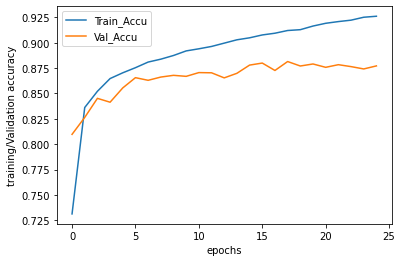

In [11]:
plt.plot(range(num_epochs),training_accuracy,label = 'Train_Accu')
plt.plot(range(num_epochs),validation_accuracy,label = 'Val_Accu')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("training/Validation accuracy")
plt.plot()

#plot for training vs validation loss

[]

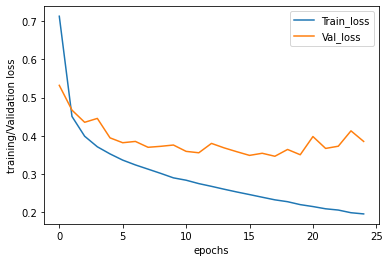

In [12]:
plt.plot(range(num_epochs),training_loss,label = 'Train_loss')
plt.plot(range(num_epochs),validation_loss,label = 'Val_loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("training/Validation loss")
plt.plot()